In [2]:
import networkx as nx

In [3]:
G = nx.karate_club_graph()

In [4]:
clubs = []  # list to populate with labels
for n in G.nodes:
  c = G.nodes[n]['club']
  clubs.append(1 if c=='Officer' else 0)

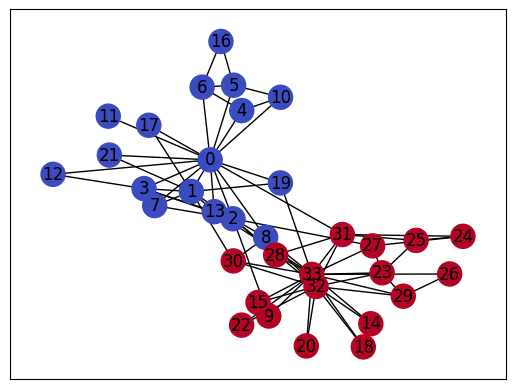

In [5]:
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx(G,pos=pos,node_color=clubs,cmap='coolwarm')

In [ ]:
!pip install karateclub

In [8]:
from karateclub import DeepWalk

## Deep Walk


In [10]:
model = DeepWalk(dimensions=124)
model.fit(G)
embedding=model.get_embedding()

In [11]:
print('Number of karate club members:', len(G.nodes))
print('Embedding array shape:', embedding.shape)

Number of karate club members: 34
Embedding array shape: (34, 124)


These vectors should reflect the graph structure, i.e. the different clubs should be far away from each other. 

We can check it by reducing the 124 dimensional data into 2 dimensional data using umap-learn package and making a scatter plot.

In [ ]:
!pip install umap-learn

In [16]:
import umap
import seaborn as sns
import pandas as pd

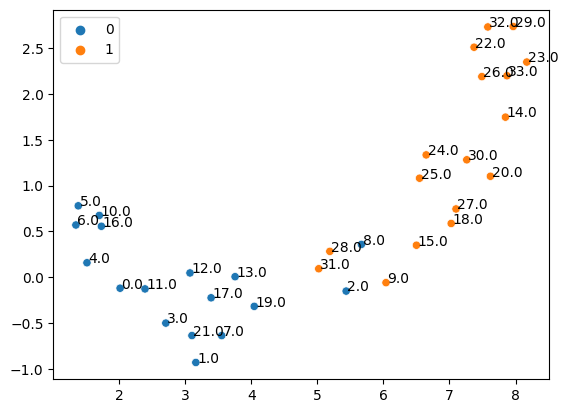

In [17]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(embedding)

ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = clubs)
a = pd.DataFrame({'x': umap_embs[:, 0], 'y': umap_embs[:, 1], 'val': G.nodes})
for i, point in a.iterrows():
    ax.text(point['x']+.02, point['y'], str(point['val']))

## Random Walk

In [23]:
import numpy as np
from karateclub import RandomWalker

In [19]:
def random_walk(start_node, walk_length):
    walk = [start_node]  # starting node
    for i in range(walk_length):
        all_neighbours = [n for n in G.neighbors(start_node)]  # get all neighbours of the node
        next_node = np.random.choice(all_neighbours, 1)[0]  # randomly pick 1 neighbour
        walk.append(next_node)  # append this node to the walk
        start_node = next_node  # this random node is now your current state
    
    return walk

Steps in random walk: [6, 4, 4, 4, 0, 1, 1, 17, 0, 13, 0, 0, 11, 11, 11, 11, 11, 0, 21, 1, 3]


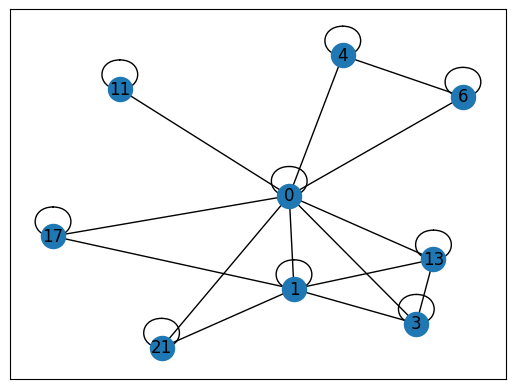

In [21]:
walk = random_walk(6, 20)  # random walk from node 6
print('Steps in random walk:', walk)
walk_graph = G.subgraph(walk)
pos = nx.spring_layout(walk_graph, seed=42)
nx.draw_networkx(walk_graph, pos=pos, cmap='coolwarm')

In [24]:
walker = RandomWalker(walk_length = 80, walk_number = 10)
walker.do_walks(G)  # you can access the walks in walker.walks 

We'll train our model (usually a simple dense neural network) with the goal to predict the nodes that appear in it's random walks.

Model's input will be the node 6 (one-hot-encoded), middle layer will be the actual embedding, and output will be prediction of the node's context.

## SKIP-gram

In [26]:
from gensim.models.word2vec import Word2Vec


In [34]:
model = Word2Vec(walker.walks,  # previously generated walks
                 hs=1,  # tells the model to use hierarchical softmax
                 sg = 1,  # tells the model to use skip-gram
                 window=5,
                 vector_size=128,
                 min_count=1,
                 workers=4,
                 seed=42)

In [35]:
embeddings = model.wv.vectors
print('Shape of embedding matrix:', embeddings.shape)

Shape of embedding matrix: (34, 128)


## FACEBOOK DATA

In [36]:
edges_path = '/content/facebook_edges.csv'
targets_path = '/content/facebook_target.csv'
features_path = '/content/facebook_features.json'

In [38]:
edges = pd.read_csv(edges_path)
edges.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:7c50d8f02a75cc0829577814a1fc1453516...
1,size 1882610
